# Using the badlands tools

This example shows you how to build a circular mesh, triangulate it and add surface process features



In [1]:
%matplotlib inline

from badlands import meshtools 
from badlands import TreMesh
from badlands import HeightMesh
from badlands import SurfaceProcessMesh

import numpy as np


/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


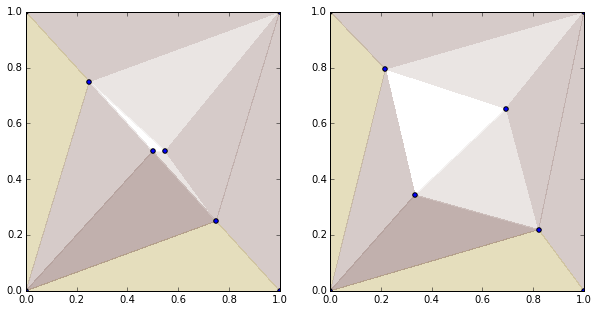

In [3]:
# A quick test mesh a small collection of points and how to build an "improved" mesh from those points


import matplotlib.pyplot as plt
from matplotlib import cm

x1 = np.array((0, 0, 1, 1, 0.5, 0.55, 0.25, 0.75 ))
y1 = np.array((0, 1, 0, 1, 0.5, 0.50, 0.75, 0.25 ))
bmask = np.array(( False, False, False, False, True, True, True, True))

phi = np.array((1, 2, 3, 4, 5, 3, 3, 2))

x5,y5 = meshtools.lloyd_mesh_improvment(x1,y1, bmask, 5)

mesh1  = TreMesh(x1,y1,bmask)
smesh5 = SurfaceProcessMesh(x5, y5, phi, phi, None, None, bmask, verbose=False)

# This is the preferred plotting strategy since it exposes the matplotlib instances
# that you need to use the plotting functions provided by TriMesh et al.

fig, (plot1, plot2) = plt.subplots(1,2)
fig.set_size_inches(10,5)
fig.set_dpi(300)

plot1.set_xlim(0.0,1.0)
plot1.set_ylim(0.0,1.0)
mesh1.add_node_data_to_plot(plot1,phi, cmap=cm.terrain, shading="flat", vmin=-0.5, alpha=0.5)

plot1.scatter(x1,y1,marker="o")

plot2.set_xlim(0.0,1.0)
plot2.set_ylim(0.0,1.0)
smesh5.add_node_data_to_plot(plot2,phi, cmap=cm.terrain, shading="flat", vmin=-0.5, alpha=0.5)
plot2.scatter(x5,y5,marker="o")



In [4]:
# Note that the help text is meaningful
help(smesh5)

Help on instance of SurfaceProcessMesh in module badlands.surfmesh.surfaceMesh:

class SurfaceProcessMesh(badlands.surfmesh.heightMesh.HeightMesh)
 |  Builds a TriMesh/HeightMesh (2D) object and adds a height field and data structures / operators
 |  to propagate information across the surface (e.g. flow downhill)
 |  
 |  Method resolution order:
 |      SurfaceProcessMesh
 |      badlands.surfmesh.heightMesh.HeightMesh
 |      badlands.tremesh.treMesh.TreMesh
 |  
 |  Methods defined here:
 |  
 |  __init__(self, points_x=None, points_y=None, height=None, rainfall_pattern=None, sediment=None, uplift=None, boundary_mask=None, verbose=None, filename=None)
 |      Initialise the Delaunay mesh (parent) and build height data structures
 |  
 |  calc_distance_to_outflow_along_chains(self)
 |      Build an array (self.node_downstream_distance) that is the 
 |      along-stream distance for any given node to the eventual outflow.
 |  
 |  calc_upstream_area_along_chains(self)
 |      Build a

In [6]:
## TEST - 2 A useful mesh for computation of surface processes. Use the elliptical mesh generator and 
## iteratively improve the points before building the 

x1, y1, bmask, inverse_bmask = meshtools.elliptical_mesh(-5.0, 5.0, -5.0,  5.0, 0.05, 0.05, 50000, 125 )
z1 = np.exp(-x1**2 -y1**2)

x5,y5 = meshtools.lloyd_mesh_improvment(x1,y1, bmask, 5)
z5 = np.exp(0.2 * (-x5**2 -y5**2)) + 0.0001 * np.random.rand(len(x5))

mesh1 = SurfaceProcessMesh(x1, y1, z1, z1**2, None, None, bmask, verbose=True)
mesh5 = SurfaceProcessMesh(x5, y5, z5, z5**2, None, None, bmask, verbose=True)

print "Mesh 1 - derivative error: ", mesh1.assess_derivative_quality()
print "Mesh 5 - derivative error: ", mesh5.assess_derivative_quality()

Origin =  0.0 0.0 Radius =  5.0 Aspect =  1.0
 - Calculating Delaunay Triangulation  0.313391 s
 - Triangulation Neighbour Lists  1.525173 s
 - Triangulation Local Areas and Weights  1.037747 s
 - Triangulation Vector Operators  1.190716 s
 - Local Smoothing Operator  0.211868 s
 - Sorted all nodes by height (high to low)  0.120215 s
 - Built downhill matrices  0.129856 s
 - Built cumulative area 0.069411 s
 - Found low points 0.015666 s
 - Found outflow points 0.014746 s
 - Calculating Delaunay Triangulation  0.326933 s
 - Triangulation Neighbour Lists  1.70326 s
 - Triangulation Local Areas and Weights  1.370024 s
 - Triangulation Vector Operators  1.322898 s
 - Local Smoothing Operator  0.274697 s
 - Sorted all nodes by height (high to low)  0.149483 s
 - Built downhill matrices  0.162593 s
 - Built cumulative area 0.065071 s
 - Found low points 0.019129 s
 - Found outflow points 0.015448 s
Mesh 1 - derivative error:  (0.014191680671025417, 0.091595367743720263)
Mesh 5 - derivative 

In [7]:
## dump the mesh to a file

mesh5.dump_to_file("MyNewMesh.npz")

In [8]:
mesh5_1 = TreMesh(filename="MyNewMesh.npz")

In [9]:
# To see what is in the data file

peakAtMeshFile = np.load("MyNewMesh.npz")
print "Available arrays: ", peakAtMeshFile.keys()
print "Rainfall distribution array: ",peakAtMeshFile['rainfall_pattern']

Available arrays:  ['triang', 'rainfall_pattern', 'height', 'bmask', 'y', 'x', 'sediment']
Rainfall distribution array:  [  5.29706589e-05   5.22350404e-05   5.07659783e-05 ...,   4.56917955e-05
   4.57315022e-05   4.54304303e-05]


In [10]:
# Here is how to update the relevant parts of the mesh if the height changes

mesh5.verbose=True
mesh5.storeDense=True
mesh5.update_height(z5)
mesh5.update_surface_processes()

# Update surface processes will reset the stored matrices and rebuild them (if storedDense is True) 
# Subsequent calls would be faster

import time

walltime=time.clock()
mesh5.cumulative_flow(mesh5.area)
print " - Built cumulative area ", time.clock() - walltime,"s"


 - Sorted all nodes by height (high to low)  0.140791 s
 - Built downhill matrices  0.116009 s
 - Built cumulative area 0.065586 s
 - Found low points 0.015424 s
 - Found outflow points 0.012432 s
 - Built cumulative area  0.057137 s


In [12]:
mesh5._build_downhill_matrices(weight=1.0) 

print mesh5.adjacency1.nnz
print mesh5.downhillMat.nnz


39310
39176


<matplotlib.colorbar.Colorbar instance at 0x123f8fa28>

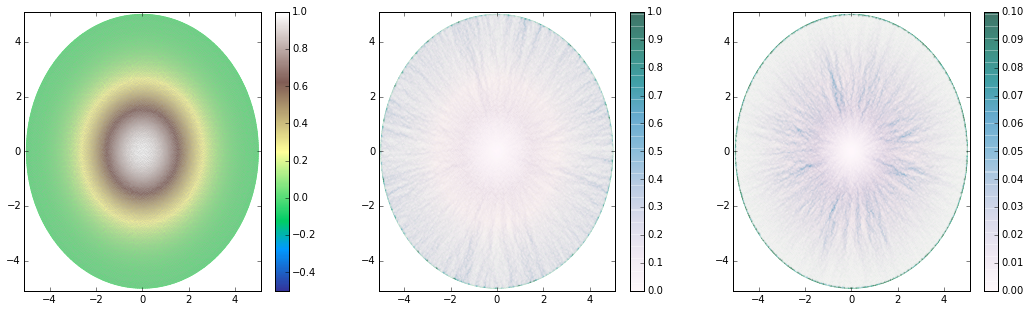

In [13]:
# This is the result 

import matplotlib.pyplot as plt
from matplotlib import cm

fig, (plot1, plot2, plot3) = plt.subplots(1,3)
fig.set_size_inches(18,5)
fig.set_dpi(300)

plot1.set_xlim(-5.1, 5.1)
plot1.set_ylim(-5.1, 5.1)
plot2.set_xlim(-5.1, 5.1)
plot2.set_ylim(-5.1, 5.1)
plot3.set_xlim(-5.1, 5.1)
plot3.set_ylim(-5.1, 5.1)

sm1 = mesh5.add_node_data_to_plot(plot1, mesh5.height, cmap=cm.terrain, shading="gouraud", vmin=-0.5)
plot1.triplot(mesh5.x, mesh5.y, mesh5.tri.simplices, color="#AAAAAA",linewidth=0.1)
    
fig.colorbar(sm1, ax=plot1)

sm1 = mesh5.add_node_data_to_plot(plot2, mesh5.height, cmap=cm.terrain, shading="gouraud", vmin=-0.5, alpha=0.5)
sm2 = mesh5.add_node_data_to_plot(plot2, mesh5.upstream_area, cmap=cm.PuBuGn, shading="gouraud", vmax=1.0, alpha=0.5)
fig.colorbar(sm2, ax=plot2)

sm1 = mesh5.add_node_data_to_plot(plot3, mesh5.height, cmap=cm.terrain, shading="gouraud", vmin=-0.5, alpha=0.5)
sm3 = mesh5.add_node_data_to_plot(plot3, mesh5.upstream_area * mesh5.slope, cmap=cm.PuBuGn, shading="gouraud", vmax=0.1, alpha=0.5)
fig.colorbar(sm3, ax=plot3)
 
# plt.show() 


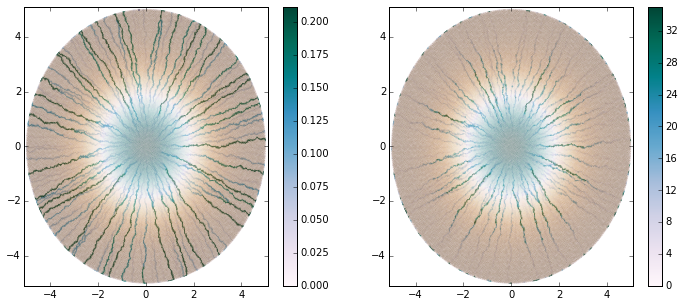

In [14]:
# We can map rainfall to outflow like this

rainfall_pattern = mesh5.height # say !
cumulative_rainfall = mesh5.cumulative_flow(mesh5.area * rainfall_pattern) 
stream_power = cumulative_rainfall * mesh5.slope


fig, (plot1, plot2) = plt.subplots(1,2)
fig.set_size_inches(12,5)

plot1.set_xlim(-5.1, 5.1)
plot1.set_ylim(-5.1, 5.1)
plot2.set_xlim(-5.1, 5.1)
plot2.set_ylim(-5.1, 5.1)

sm1a = mesh5.add_node_data_to_plot(plot1,cumulative_rainfall, cmap=cm.PuBuGn, shading="gouraud", vmax=cumulative_rainfall[bmask].max()*0.5)
sm1b = mesh5.add_node_data_to_plot(plot1, rainfall_pattern, cmap=cm.BrBG, shading="gouraud", alpha=0.1)
if len(mesh5.low_points):
    plot1.scatter(mesh5.x[mesh5.low_points], mesh5.y[mesh5.low_points],2, marker="o", alpha=0.25)


fig.colorbar(sm1a, ax=plot1)

# Or this

rainflux = np.exp(-0.2*((mesh5.x-1.25)**2 + mesh5.y**2))**2
rainfall = mesh5.area * rainflux 
cumulative_rain = mesh5.cumulative_flow(rainfall)

sm2a = mesh5.add_node_data_to_plot(plot2, stream_power / mesh5.area, cmap=cm.PuBuGn, shading="gouraud", vmax=(stream_power[bmask]/mesh5.area[bmask]).max()*0.5)
sm2b = mesh5.add_node_data_to_plot(plot2, rainfall_pattern, cmap=cm.BrBG, shading="gouraud", alpha=0.1)
fig.colorbar(sm2a, ax=plot2)

fig.savefig("eyeballs", dpi=600)